In [1]:
! pip install -q kaggle

In [2]:
!pip install transformers


     |████████████████████████████████| 2.6 MB 7.7 MB/s 
     |████████████████████████████████| 636 kB 58.7 MB/s 
     |████████████████████████████████| 3.3 MB 60.9 MB/s 
     |████████████████████████████████| 895 kB 64.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install unidecode
!pip install torch
!pip install tqdm

     |████████████████████████████████| 241 kB 8.4 MB/s 


In [46]:
from google.colab import files
from tqdm import tqdm
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [5]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle competitions download -c home-depot-product-search-relevance

 33% 9.00M/27.2M [00:00<00:00, 29.3MB/s]
100% 27.2M/27.2M [00:00<00:00, 61.4MB/s]
100% 4.74M/4.74M [00:00<00:00, 48.5MB/s]

  0% 0.00/227k [00:00<?, ?B/s]
100% 227k/227k [00:00<00:00, 70.0MB/s]
  0% 0.00/105k [00:00<?, ?B/s]
100% 105k/105k [00:00<00:00, 112MB/s]
 95% 33.0M/34.8M [00:01<00:00, 26.4MB/s]
100% 34.8M/34.8M [00:01<00:00, 30.0MB/s]
  0% 0.00/2.51M [00:00<?, ?B/s]
100% 2.51M/2.51M [00:00<00:00, 151MB/s]


In [29]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import nltk 
import unidecode
import re
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
!ls

attributes.csv.zip	      relevance_instructions.docx  test.csv.zip
kaggle.json		      sample_data		   train.csv.zip
product_descriptions.csv.zip  sample_submission.csv.zip


In [12]:
att_df= pd.read_csv('attributes.csv.zip')
desc_df= pd.read_csv('product_descriptions.csv.zip')
train_df= pd.read_csv('train.csv.zip', encoding='latin-1')
test_df = pd.read_csv('test.csv.zip',encoding='latin-1')


In [14]:
desc_df = desc_df.fillna(0)
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)
att_df = att_df.fillna(0)

desc_df['product_uid'] = desc_df['product_uid'].astype(np.int64)
train_df['product_uid'] = train_df['product_uid'].astype(np.int64)
test_df['product_uid'] = test_df['product_uid'].astype(np.int64)
att_df['product_uid'] = att_df['product_uid'].astype(np.int64)

In [16]:
train_df.sample(2)

,id,product_uid,product_title,search_term,relevance
26071,79939,123316,KOHLER CLC 30 in. x 26 in. Recessed or Surface...,bath si k cabinets,2.67
36027,110117,135898,Burpee Spinach Bloomsdale Long-Standing Seed,spinach,3.00


In [ ]:
np.min(train_df['relevance'].tolist()), np.max(train_df['relevance'].tolist())

(1.0, 3.0)

In [17]:
train_df['my_relevance'] = train_df['relevance'].apply(lambda x: (x - 1.0)/2.0)

In [18]:
np.min(train_df['my_relevance'].tolist()), np.max(train_df['my_relevance'].tolist())

(0.0, 1.0)

In [19]:
train_df['my_relevance2'] = train_df['my_relevance'].apply(lambda x: ((x - 0.0)/1.0) * 2.0 + 1)

In [20]:
train_df[['relevance', 'my_relevance', 'my_relevance2']].sample(4)

,relevance,my_relevance,my_relevance2
52071,2.33,0.665,2.33
12742,1.67,0.335,1.67
13883,3.00,1.000,3.00
36757,1.00,0.000,1.00


In [ ]:
train_df.describe()

,id,product_uid,relevance
count,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634
std,64016.573650,30770.774864,0.533984
min,2.000000,100001.000000,1.000000
25%,57163.500000,115128.500000,2.000000
50%,113228.000000,137334.000000,2.330000
75%,168275.500000,166883.500000,3.000000
max,221473.000000,206650.000000,3.000000


In [23]:
train_df.drop_duplicates(["product_uid"]).shape[0]/len(train_df)

0.7380749861611784

In [ ]:
# pd.merge(train_df, desc_df, how='left', on='product_uid').shape[0]

74067

In [24]:
train_df.shape[0]

74067

In [25]:
EMPTY_STRING = ''
SPACE = ' '
def clean_text(string):
  if string is None:
    return None

  string = string.strip().lower()
  string = unidecode.unidecode(string)
  string = string.replace("'", EMPTY_STRING)
  string = re.sub(r"\'n", SPACE, string)
  string = re.sub(r"\'s", " 's", string)
  string = re.sub(r"\'ve", " 've", string)
  string = re.sub(r"n\'t", " n't", string)
  string = re.sub(r"\'re", " 're", string)
  string = re.sub(r"\'d", " 'd", string)
  string = re.sub(r"\'ll", " 'll", string)
  string = re.sub(r",", " , ", string)
  string = re.sub(r"!", " ! ", string)
  string = re.sub(r"\(", " ( ", string)
  string = re.sub(r"\)", " ) ", string)
  string = re.sub(r"\?", r" \? ", string)
  string = re.sub(r"\s{2,}", SPACE, string)
  string = re.sub(r" +", SPACE, string)
  string = re.sub(r"/", " / ", string)
  string = re.sub(r"\|", " | ", string)
  string = re.sub(r"-", " - ", string)
  string = re.sub(r"\+", " + ", string)
  string = re.sub(r"\\\\", SPACE, string)

  return string.strip()


In [36]:
_characters_to_clean = string.punctuation + "''"
EN_STOP_WORDS = set(stopwords.words('english')) - set(['can', 'no', 'up', 'against', 'after', 'before', 'below'])

PUNCTUATIONS = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~'

PUNCTUATIONS_PATTERN = re.compile("[{}]+$".format(re.escape(PUNCTUATIONS)))

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def _is_punctuation_only(word: str):
    return PUNCTUATIONS_PATTERN.match(word)

def filter_ale_punctuation(words):
    return [word for word in words if not _is_punctuation_only(word)] if words is not None else None

def tokenize(text):
  
  processed_text = clean_text(text)
  tokens = nltk.word_tokenize(processed_text)

  
  tokens = [stemmer.stem(word) for word in tokens]
  tokens = [word for word in tokens if word not in _characters_to_clean and word not in EN_STOP_WORDS]
  tokens = filter_ale_punctuation(tokens)
  tokens = [re.sub("\d", "#", word) for word in tokens]

  return tokens if len(tokens) > 0 else None


In [40]:
# tokenize("he went home 123 times, before we --gabi op. -;[]")

['went', 'home', '###', 'time', 'befor', 'gabi', 'op']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


0.9997299742125373

In [48]:
train_df['product_title_tokens'] = train_df['product_title'].progress_apply(tokenize)

100%|██████████| 74067/74067 [00:35<00:00, 2096.44it/s]


In [47]:
train_df['search_term_tokens'] = train_df['search_term'].progress_apply(tokenize)

100%|██████████| 74067/74067 [00:14<00:00, 5141.27it/s]


In [196]:

test_df['product_title_tokens'] = test_df['product_title'].progress_apply(tokenize)



  5%|▌         | 9059/166693 [00:04<01:20, 1956.27it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f12ce48dd40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'

100%|██████████| 166693/166693 [01:26<00:00, 1930.85it/s]


In [197]:
test_df['search_term_tokens'] = test_df['search_term'].progress_apply(tokenize)


100%|██████████| 166693/166693 [00:31<00:00, 5305.03it/s]


In [ ]:
pd.set_option("max_colwidth", -1)

original_train_df_length = len(train_df)
train_df = train_df[train_df['search_term_tokens'].notnull()]
len(train_df)/original_train_df_length

In [50]:
train_df.sample(3)

,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens
58288,176171,171947,GE 6.6 cu. ft. Double Oven Electric Range with...,stainless steel electric range and microwave,2.67,0.835,2.67,"[ge, #.#, cu, ft., doubl, oven, electr, rang, ...","[stainless, steel, electr, rang, microwav]"
51449,156266,159633,Elkay Lustertone Top Mount Stainless Steel 15 ...,elkay bar sink,3.00,1.000,3.00,"[elkay, lusterton, top, mount, stainless, stee...","[elkay, bar, sink]"
14509,44793,111005,LEXAN Thermoclear 48 in. x 96 in. x 1/4 in. Cl...,plasticl panels,2.00,0.500,2.00,"[lexan, thermoclear, ##, x, ##, x, #, #, clear...","[plasticl, panel]"


In [79]:
all_words = [word for words in train_df['search_term_tokens'].tolist() for word in words]
all_words.extend([word for words in train_df['product_title_tokens'].tolist() for word in words])


(10328, 1055648)

In [80]:
WORD_REPLACE_MENT = '<word>'
PAD_WORD = "<pad>"

In [67]:
# from collections import Counter
# sentenses = train_df['search_term_tokens'].tolist()
# sentenses.extend(train_df['product_title_tokens'].tolist())
counts = Counter(all_words)


In [72]:
MIN_WORD_COUNT = 3

In [82]:
vocab_words = set(all_words)
vocab_size_before_threshold = len(vocab_words)
vocab_words = {word for word in vocab_words if counts[word] >= MIN_WORD_COUNT}
vocab_size_before_threshold, len(vocab_words), len(all_words)

(10328, 10327, 1055648)

In [73]:
train_df['product_title_tokens'] = train_df['product_title_tokens'].progress_apply(lambda words: [word if counts[word] >= MIN_WORD_COUNT else WORD_REPLACE_MENT for word in words])


100%|██████████| 74047/74047 [00:00<00:00, 116211.52it/s]


In [76]:
train_df['search_term_tokens'] = train_df['search_term_tokens'].progress_apply(lambda words: [word if counts[word] >= MIN_WORD_COUNT else WORD_REPLACE_MENT for word in words])


100%|██████████| 74047/74047 [00:00<00:00, 428675.82it/s]


In [198]:
test_df['product_title_tokens'] = test_df['product_title_tokens'].progress_apply(lambda words: [word if counts[word] >= MIN_WORD_COUNT else WORD_REPLACE_MENT for word in words])
test_df['search_term_tokens'] = test_df['search_term_tokens'].progress_apply(lambda words: [word if counts[word] >= MIN_WORD_COUNT else WORD_REPLACE_MENT for word in words])


100%|██████████| 166693/166693 [00:01<00:00, 158140.07it/s]

  0%|          | 0/166693 [00:00<?, ?it/s]

TypeError: ignored

In [77]:
train_df[train_df['product_title_tokens'].map(len) == 0]

,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens


In [78]:
train_df[train_df['search_term_tokens'].map(len) == 0]

,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens


In [113]:
vocab = {word: index + 2 for (index, word) in enumerate(vocab_words)}
vocab[PAD_WORD] = 0 
vocab[WORD_REPLACE_MENT] = 1
PAD_WORD_ID = vocab[PAD_WORD]

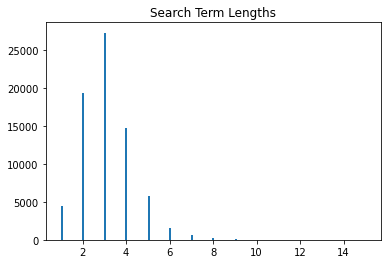

In [85]:
import matplotlib.pyplot as plt

search_term_lengths = train_df['search_term_tokens'].map(len).tolist()
_ = plt.hist(search_term_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Search Term Lengths")
plt.show()

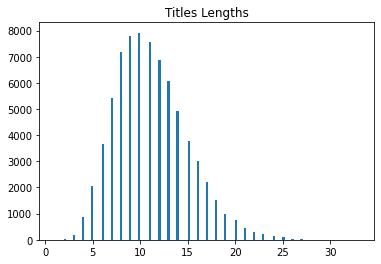

In [86]:
import matplotlib.pyplot as plt

title_lengths = train_df['product_title_tokens'].map(len).tolist()
_ = plt.hist(title_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Titles Lengths")
plt.show()

In [87]:
MAX_SEARCH_TERM_LENGTH = 5
MAX_TITLE_LENGTH = 15

In [203]:
import random
import time
random.seed(int(time.time()))
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn, utils
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.optim.lr_scheduler import ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

class DatasetLoader(Dataset):

    def __init__(self, df, vocab):
        self._df = df
        self._vocab = vocab

    def __len__(self):
        return len(self._df)

    def _fix_words(self, words_ids, required_size):
        if len(words_ids) > required_size:
            ids = np.random.choice(len(words_ids), required_size)
            words_ids = words_ids[ids]
        elif len(words_ids) < required_size:
            b = np.zeros(required_size - len(words_ids), dtype=int)
            words_ids = np.concatenate((words_ids, b), axis=None)

        return words_ids

    def __getitem__(self, idx):
        row = self._df.iloc[idx]

        search_term = np.array([self._vocab[w] for w in row['search_term_tokens']])
        search_term_length = min(len(search_term), MAX_SEARCH_TERM_LENGTH)
        search_term = self._fix_words(search_term, MAX_SEARCH_TERM_LENGTH)


        product_title = np.array([self._vocab[w] for w in row['product_title_tokens']])
        product_title_length = min(len(product_title), MAX_SEARCH_TERM_LENGTH)
        product_title = self._fix_words(product_title, MAX_TITLE_LENGTH)

   

        return row['id'], search_term, search_term_length, product_title, product_title_length, row['my_relevance']
    


,id,product_uid,product_title,search_term,relevance,my_relevance,my_relevance2,product_title_tokens,search_term_tokens
41226,125601,143225,Bosch Fast Spiral Masonry Set (14-Piece),concrete drill bits,2.67,0.835,2.67,"[bosch, fast, spiral, masonri, set, ##, piec]","[concret, drill, bit]"


In [204]:
BATCH_SIZE = 32
data_loader = DatasetLoader(train_df[['id', 'product_title_tokens', 'search_term_tokens', 'my_relevance']], vocab)

train_data_loader = torch.utils.data.DataLoader(data_loader,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)

test_df['my_relevance'] = -1

test_loader = DatasetLoader(test_df[['id', 'product_title_tokens', 'search_term_tokens', 'my_relevance']], vocab)

test_data_loader = torch.utils.data.DataLoader(test_loader,
                                                 batch_size=BATCH_SIZE, shuffle=False, 
                                                 num_workers=4,drop_last=False)


In [205]:
for ids, search_term, search_term_length, product_title, product_title_length, relevance_score in train_data_loader:
  break

In [107]:
search_term.shape, search_term_length.shape , product_title.shape , product_title_length.shape  

(torch.Size([32, 5]), torch.Size([32]), torch.Size([32, 15]), torch.Size([32]))

In [191]:
class EncoderModel(nn.Module):

    def __init__(self, n_vocab):
        super(EncoderModel, self).__init__()
        self.lstm_size = 100
        self.embedding_dim = 300
        

        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )

        self.rnn = nn.GRU(self.embedding_dim, 200, 1, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(400, 200)
        self.fc2 = nn.Linear(200, 100)

    def forward(self, x, lengths):

        embed = self.embedding(x)
            
        packed_input = pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)
        
        packed_output, hn = self.rnn(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        out_forward = output[range(len(output)), lengths - 1, :self.embedding_dim ]
        out_reverse = output[:, 0, self.embedding_dim :]
        out = torch.cat((out_forward, out_reverse), 1)
        
        #out = torch.tanh(out_reduced)
        out = self.fc1(out)
        out = torch.tanh(out)
        out = self.fc2(out)

        return out
    
    def reset_parameters(self):
        nn.init.uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc2.weight)

        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        

class RelevanceModel(nn.Module):

  def __init__(self, n_vocab):
    super(RelevanceModel, self).__init__()
    self.query_encoder = EncoderModel(n_vocab)#.to(device)
    self.title_encoder = EncoderModel(n_vocab)#.to(device)
    self.fc = nn.Linear(200, 1)

  def  forward(self, queries, titles, queries_lengths, titles_lengths):
    encoded_queries = self.query_encoder(queries, queries_lengths)
    title_encoded = self.title_encoder(titles, titles_lengths)

    out = torch.cat((encoded_queries, title_encoded), 1)
    out = torch.tanh(out)

  
    out = self.fc(out)

    return torch.sigmoid(out)

  def reset_parameters(self):
    nn.init.uniform_(self.fc.weight)
    self.query_encoder.reset_parameters()
    self.title_encoder.reset_parameters()
    

# class RelevanceModel(nn.Module):

#   def __init__(self, n_vocab):
#     super(RelevanceModel, self).__init__()
#     self.encoder = EncoderModel(n_vocab)#.to(device)
#     #self.title_encoder = EncoderModel(n_vocab)#.to(device)
#     self.fc = nn.Linear(200, 1)

#   def  forward(self, queries, titles, queries_lengths, titles_lengths):
#     encoded_queries = self.encoder(queries, queries_lengths)
#     encoded_queries = self.encoder(titles, titles_lengths)

#     out = torch.cat((query_encoded, title_encoded), 1).to(device)
#     out = torch.tanh(out)

  
#     out = self.fc(out)

#     return torch.sigmoid(out)

#   def reset_parameters(self):
#     nn.init.uniform_(self.fc.weight)
#     self.encoder.reset_parameters()
    


In [164]:

for x in model.parameters():
  if not x.is_cuda:
    print(x) 

In [188]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
# query_encoder = EncoderModel(len(vocab))
# title_encoder = EncoderModel(len(vocab))

# query_encoder.reset_parameters()
# title_encoder.reset_parameters()

# #search_term, search_term_length, product_title, product_title_length
# query_encoded = query_encoder(search_term, search_term_length)
# title_encoded = query_encoder(product_title, product_title_length)
# torch.cat((query_encoded, title_encoded), 1)

In [133]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [192]:
model = RelevanceModel(len(vocab))
model.reset_parameters()
model.to(device)

optimizer = torch.optim.Adam(
        model.parameters(), lr=0.001)

mse_loss  = nn.MSELoss()


# model(search_term, product_title, search_term_length,  product_title_length)

In [149]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [178]:
# loss.backward

AttributeError: ignored

In [194]:

model.train()

for epoc in range(1000):

  running_loss = 0.0
  counter = 0.0

  for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    target_relevance_score = Variable(target_relevance_score).float().to(device)

    model.zero_grad()

    scores = model(search_term, product_title, search_term_length,  product_title_length)
    loss = mse_loss(scores, target_relevance_score)

    

    loss.backward()
    optimizer.step()

    #nn.utils.clip_grad_norm(model.parameters(), 0.5)
    
    running_loss += loss.item()
    counter = search_term.shape[0]
  
  print('epoc {} loss {}'.format(epoc, running_loss/counter))




epoc {} loss {} 0 8.18026417998537
epoc {} loss {} 1 6.744423832504019
epoc {} loss {} 2 6.595475179293463
epoc {} loss {} 3 6.178812862764443
epoc {} loss {} 4 6.1850681349394785
epoc {} loss {} 5 6.187504166797284
epoc {} loss {} 6 6.195774588854082
epoc {} loss {} 7 6.166055038811699
epoc {} loss {} 8 6.166494425446276
epoc {} loss {} 9 6.173135533808701
epoc {} loss {} 10 6.165904410724198
epoc {} loss {} 11 6.166599967847428
epoc {} loss {} 12 6.16863685149339
epoc {} loss {} 13 6.1767906092347635
epoc {} loss {} 14 6.188229101439638
epoc {} loss {} 15 6.18884974934401
epoc {} loss {} 16 6.037252544755897
epoc {} loss {} 17 5.917392993165601
epoc {} loss {} 18 5.931993352970289
epoc {} loss {} 19 5.927508187269972
epoc {} loss {} 20 5.915603622673981
epoc {} loss {} 21 5.924302497998841
epoc {} loss {} 22 5.928974196254726
epoc {} loss {} 23 5.934779988481633
epoc {} loss {} 24 5.925739924633695
epoc {} loss {} 25 5.922407688693173
epoc {} loss {} 26 5.930698613245641
epoc {} loss

KeyboardInterrupt: ignored

In [216]:
test_data_loader

model.train()
test_scores = []
test_ids =[]
for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in train_data_loader:
  search_term = Variable(search_term).to(device)
  product_title = Variable(product_title).to(device)
  target_relevance_score = Variable(target_relevance_score).float().to(device)

  scores = model(search_term, product_title, search_term_length,  product_title_length)

  test_scores.extend(scores.detach().cpu().numpy().flatten().tolist())
  test_ids.extend(ids.numpy().tolist())
  



In [219]:
test_scores[0:100]

[0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.0,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715550422668457,
 0.6715